Вступительная информация для Задания 1:
Приложение - мобильная утилита для сканирования документов. Модель монетизации
подписочная, есть пробный период 7 дней с дальнейшим переходом в оплату 4.99 USD
в неделю. По ссылке ниже выгрузка с базы данных по оформлениям подписок и оплат.
Каждая строка представляет собой отдельное событие (либо оформление пробной
подписки, либо оплата после завершения пробного периода). Задание построено таким
образом, чтобы проверить понимание принципов unit-экономики предприятия. Задание
1 предпочтительней делать с помощью Python.

### Задание 1
1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ
(cohorting event - оформление пробного периода, когорта представляет собой кол-во
возможных операций).
2. Спрогнозировать, каким будет LTV на полгода.
3. Построить график, который будет отображать кривую фактического LTV на
фоне кривой прогнозируемого LTV.
4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения
платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский,
цель: узнать как окупятся наши инвестиции).

## 1. Импорт необходимых библиотек

In [2]:
import pandas as pd
import numpy as np
from scipy import optimize
from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

%matplotlib inline

### Функции, использованные в коде

In [3]:
def revenue_by_week(trial):
    revenue = 0
    if trial == False:
        revenue = 4.99
    return revenue

In [4]:
def ltv_func(param):
    result = coefs_l[0] + coefs_l[1]*np.log(param)
    return result

## 2. Предобработка данных 

Данные

In [5]:
fileurl   = r'https://drive.google.com/file/d/1L8843A80r50_e-hU79XV_ssAfzgQVUDP/view?usp=sharing'
filedlurl = r'https://drive.google.com/u/0/uc?id=1L8843A80r50_e-hU79XV_ssAfzgQVUDP&export=download'

data = pd.read_excel(filedlurl)
data.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
print('Количество уникальных значений в каждом столбце:', data.nunique(), sep='\n')

Количество уникальных значений в каждом столбце:
product_id             1
quantity               1
is_trial_period        2
purchase_date         51
user_id            62909
dtype: int64


In [8]:
print('Есть ли нули в каждом столбце:', data.isnull().any(), sep='\n')

Есть ли нули в каждом столбце:
product_id         False
quantity           False
is_trial_period    False
purchase_date      False
user_id            False
dtype: bool


## 3. Рассчет LTV юзера, используя когортный анализ 

In [9]:
data.purchase_date.min()

Timestamp('2020-01-01 00:00:00')

In [10]:
data.purchase_date.max()

Timestamp('2020-02-20 00:00:00')

Для каждого пользователя найдем дату и время его первой сессии на сайте. Запишем, полученный результат в новый датафрейм.

In [11]:
mindate = data.sort_values('purchase_date').drop_duplicates('user_id')

In [12]:
mindate.shape

(62909, 5)

In [13]:
mindate = mindate[['user_id','purchase_date']]

In [14]:
mindate = mindate.rename(columns = {'purchase_date' : 'cohort_by_first_session'})
mindate.head()

,user_id,cohort_by_first_session
102315,8190554,2020-01-01
99730,8186961,2020-01-01
99720,8169617,2020-01-01
112712,8205643,2020-01-01
111387,8198989,2020-01-01


Объединим полученный датафрейм с исходным

In [15]:
df = data.merge(mindate, how='left', on='user_id')
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,cohort_by_first_session
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,2020-02-11
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,2020-01-19


In [16]:
#Добавим новые столбцы с инофрмацией об активности по неделям
df['activity_week'] = df['purchase_date'].astype('datetime64[W]')
df['cohort_by_first_session_week'] = df['cohort_by_first_session'].astype('datetime64[W]')

df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,cohort_by_first_session,activity_week,cohort_by_first_session_week
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12,2020-02-13,2020-02-06
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10,2020-02-13,2020-02-06
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11,2020-02-13,2020-02-06
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,2020-02-11,2020-02-13,2020-02-06
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,2020-01-19,2020-02-13,2020-01-16


In [17]:
#Посчитаем время жизни для каждого события в неделях
df['cohort_lifetime'] = df['activity_week'] - df['cohort_by_first_session_week']
df['cohort_lifetime'] = (df['cohort_lifetime'] / np.timedelta64(1,'W')).round().astype('int')
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,cohort_by_first_session,activity_week,cohort_by_first_session_week,cohort_lifetime
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12,2020-02-13,2020-02-06,1
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10,2020-02-13,2020-02-06,1
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11,2020-02-13,2020-02-06,1
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,2020-02-11,2020-02-13,2020-02-06,1
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,2020-01-19,2020-02-13,2020-01-16,4


In [18]:
df.cohort_lifetime.unique()               

array([1, 4, 2, 3, 6, 5, 7, 8, 0])

In [19]:
# Добавим столбец с доходом по подписке
df['revenue'] = df.is_trial_period.apply(revenue_by_week)

In [20]:
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,cohort_by_first_session,activity_week,cohort_by_first_session_week,cohort_lifetime,revenue
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12,2020-02-13,2020-02-06,1,4.99
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10,2020-02-13,2020-02-06,1,4.99
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11,2020-02-13,2020-02-06,1,4.99
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,2020-02-11,2020-02-13,2020-02-06,1,4.99
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,2020-01-19,2020-02-13,2020-01-16,4,4.99


In [21]:
# Посчитаем количество новых юзеров в неделю
cohort_size = df.groupby(['cohort_by_first_session_week'])\
            .agg({'user_id':'nunique'}).reset_index()\
            .rename(columns={'user_id':'w_n_users'})
cohort_size.head()

,cohort_by_first_session_week,w_n_users
0,2019-12-26,906
1,2020-01-02,9398
2,2020-01-09,8927
3,2020-01-16,8983
4,2020-01-23,7732


In [22]:
# Создадим новый датафрейм с информацией о когортах и их куммулятивной суммой
cumsum_revenue_by_cohort = df.groupby(['cohort_by_first_session_week','cohort_lifetime'])\
                             .agg({'revenue':'sum'})\
                             .groupby(level=0).cumsum()\
                             .rename(columns={'revenue':'cohort_cumsum'}).reset_index()
cumsum_revenue_by_cohort.head()

,cohort_by_first_session_week,cohort_lifetime,cohort_cumsum
0,2019-12-26,0,4.99
1,2019-12-26,1,1596.80
2,2019-12-26,2,2998.99
3,2019-12-26,3,4251.48
4,2019-12-26,4,5349.28


In [23]:
#Объединим количество пользователей когорты и куммулятивную сумму дохода в когорте
report = pd.merge(cohort_size, cumsum_revenue_by_cohort, on='cohort_by_first_session_week')


In [24]:
report['LTV'] = report['cohort_cumsum'] / report['w_n_users']
report['LTV'] = report['LTV'].round(2)

In [25]:
report.head()

,cohort_by_first_session_week,w_n_users,cohort_lifetime,cohort_cumsum,LTV
0,2019-12-26,906,0,4.99,0.01
1,2019-12-26,906,1,1596.80,1.76
2,2019-12-26,906,2,2998.99,3.31
3,2019-12-26,906,3,4251.48,4.69
4,2019-12-26,906,4,5349.28,5.90


In [26]:
LTV_pivot = report.pivot_table(index='cohort_by_first_session_week', 
                         columns = 'cohort_lifetime', 
                         values = 'LTV',  
                         aggfunc='mean')
LTV_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8
cohort_by_first_session_week,,,,,,,,,
2019-12-26,0.01,1.76,3.31,4.69,5.90,7.10,8.16,9.16,9.18
2020-01-02,0.00,1.84,3.30,4.61,5.80,6.88,7.83,7.88,NaN
2020-01-09,0.00,1.71,3.08,4.29,5.33,6.28,6.32,NaN,NaN
2020-01-16,0.00,1.63,2.94,4.07,5.06,5.11,NaN,NaN,NaN
2020-01-23,0.00,1.58,2.78,3.79,3.84,NaN,NaN,NaN,NaN
2020-01-30,0.00,1.57,2.75,2.82,NaN,NaN,NaN,NaN,NaN
2020-02-06,0.00,1.59,1.66,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-13,0.00,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-20,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


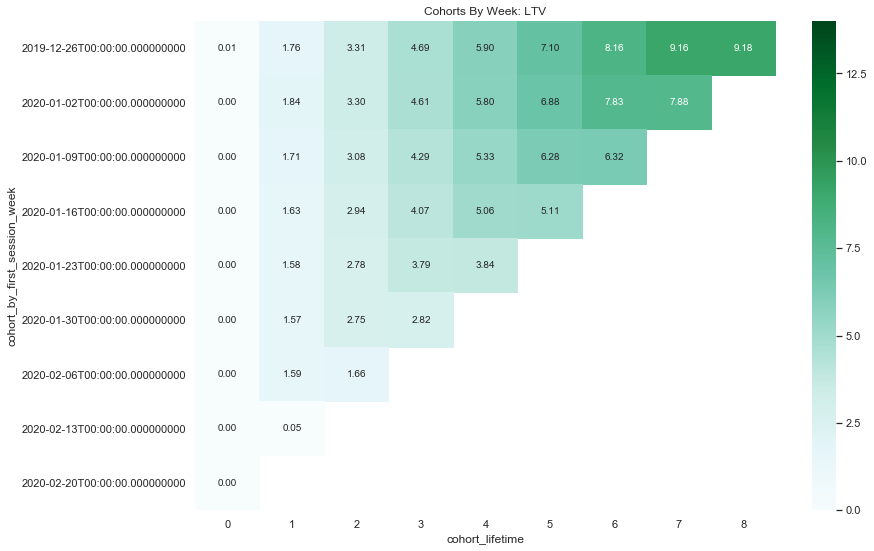

In [27]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts By Week: LTV')
sns.heatmap(LTV_pivot, annot=True,  fmt='.2f', vmin = 0,vmax = 14,cmap = 'BuGn');
plt.show()

## 4. Прогнозирование LTV

In [28]:
#Создадим датафоейм, содержащий информацию о среднем значении LTV и номер когорты, соотвествующий неделе подписки.
LTV_by_week = report.groupby(['cohort_lifetime'])\
                    .agg({'LTV':'mean'}).reset_index()

In [29]:
report.cohort_by_first_session_week.min()

Timestamp('2019-12-26 00:00:00')

In [30]:
LTV_by_week.rename(columns={'cohort_lifetime':'w', 'LTV':'y'}, inplace=True)

Text(0, 0.5, 'LTV')

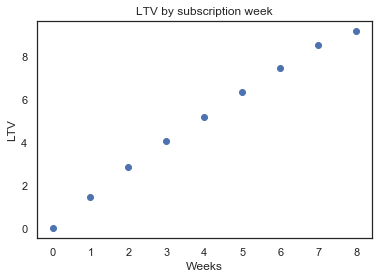

In [31]:
plt.scatter(LTV_by_week['w'], LTV_by_week['y'])
plt.title('LTV by subscription week')
plt.xlabel('Weeks')
plt.ylabel('LTV')

Выполним простое прогнозирование при помощи функции логарифма

In [32]:
x = LTV_by_week['w']
y = LTV_by_week['y']

In [33]:
X_l = LTV_by_week[LTV_by_week.w != 0].w
Y_l = LTV_by_week[LTV_by_week.w != 0].y.round(2)

In [34]:
coefs_l, cov = optimize.curve_fit(lambda t,a,b: a + b * np.log(t),  X_l,  Y_l, maxfev=1000)
print(coefs_l)

[0.59941784 3.79218888]


In [35]:
ltv_9_26 = ltv_func([9., 26.])
ltv9 = round(ltv_9_26[0],2)
ltv26 = round(ltv_9_26[1],2)

print ('LTV by week number 9: ', ltv9)
print ('LTV by week number 26: ', ltv26)

LTV by week number 9:  8.93
LTV by week number 26:  12.95


Text(0.5, 1.0, 'Prediction of LTV by subscription week')

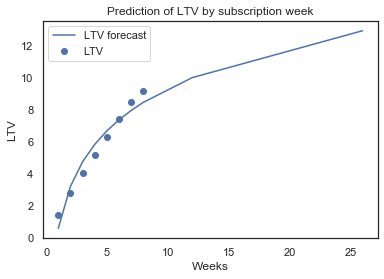

In [36]:
weeks = np.hstack([LTV_by_week[LTV_by_week.w != 0].w, [12, 26]])
plt.scatter(LTV_by_week[LTV_by_week.w != 0].w ,LTV_by_week[LTV_by_week.w != 0].y)
plt.plot(weeks,ltv_func(weeks.reshape(-1, 1)))
plt.xlabel('Weeks')
plt.ylabel('LTV')
plt.legend(['LTV forecast', 'LTV'])
plt.title('Prediction of LTV by subscription week')

Прогнозирование при помощи библиотеки Prophet


In [38]:
# для прогнозирования при помощи prophet введем новую колонку с данными по дате
LTV_by_week['data'] = pd.to_datetime( LTV_by_week['w'] * 7, origin='2019-12-26', unit='d')

In [39]:
#Переименовываем столбцы
LTV_by_week.rename(columns={'data':'ds'}, inplace=True)

In [40]:
LTV_by_week['cap'] = 13

In [41]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 2

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = LTV_by_week[:-predictions]

In [42]:
m = Prophet(growth='logistic', n_changepoints = 3, daily_seasonality=False, 
            weekly_seasonality=False, yearly_seasonality=False)
m.fit(train_df)

In [43]:
# Предсказываем 
future = m.make_future_dataframe(periods=14, freq='d')
future['cap'] = 12
forecast = m.predict(future)

C:\Users\matis\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\matis\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


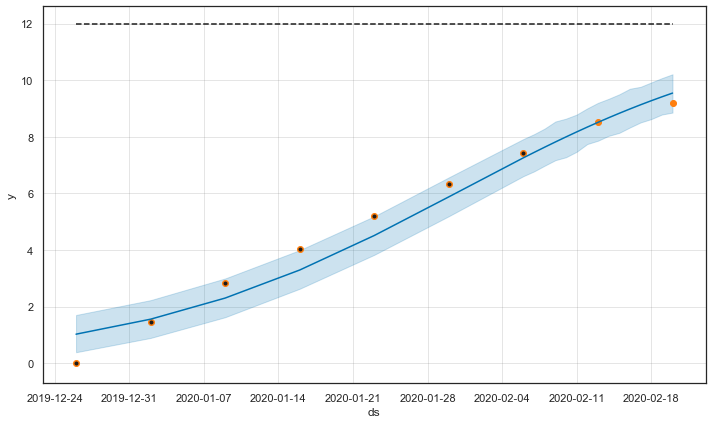

In [44]:
# Смотрим, что предсказалось
m.plot(forecast)
plt.scatter(LTV_by_week['ds'], LTV_by_week['y'], c='#ff7f0e')

На графике изображены исходные данные(оранжевые точки), модель(синяя линия), ошибки модели (голубая тень) 

In [45]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(LTV_by_week.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']

print('MAPE(средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE(средняя абсолютная ошибка в процентах) –  3.9512916356174608 %
MAE (средняя абсолютная ошибка) –  0.3627285721496829


In [46]:
MAPE = round(np.mean(abs(cmp_df[-predictions:]['p'])), 2)

In [47]:
# Прогнозируем на полный период (указываем количество недель)
final_train_df = LTV_by_week
f = Prophet( daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False, 
            n_changepoints = 3, growth='logistic')
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=18, freq='w')
final_future['cap'] = 12
final_forecast = f.predict(final_future)

C:\Users\matis\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\matis\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


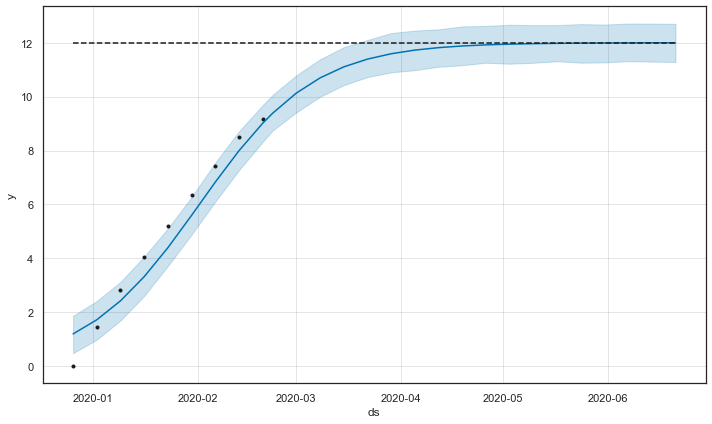

In [48]:
# Смотрим, что предсказалось на полный период
final_prediction_26_weeks = f.plot(final_forecast)

In [55]:
final_forecast.tail(3)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
24,2020-06-07,11.993166,12,11.314575,12.711160,11.993166,11.993166,0.0,0.0,0.0,0.0,0.0,0.0,11.993166
25,2020-06-14,11.995476,12,11.298400,12.708414,11.995476,11.995476,0.0,0.0,0.0,0.0,0.0,0.0,11.995476
26,2020-06-21,11.997005,12,11.286260,12.699429,11.997005,11.997005,0.0,0.0,0.0,0.0,0.0,0.0,11.997005


В прогнозе каждая дата соотвествует неделе подсписки начиная с 0 до 26. При этом за 0 неделю принята неделя, начинающаяся 2019-12-26

Существует модель прогнозирования Pareto/NBD, которая часто применяется именно для предсказания метрики LTV, но я пока не успела с ней разобраться.

## 5. Расчет ROMI

Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский, цель: узнать как окупятся наши инвестиции).

ROMI = (LTV(t) - стоимость привлечения) / стоимость привлечения х 100%

### ROMI на 4-й неделе

In [56]:
print('LTV на 4ой недели ', LTV_by_week.y[3])

LTV на 4ой недели  4.045


In [57]:
print('ROMI на 4ой неделе ', round((LTV_by_week.y[3] - 6) / 6 * 100, 2), '%')

ROMI на 4ой неделе  -32.58 %


### ROMI через полгода (26 неделя)

In [58]:
print('По вышеполученному прогнозу LTV через полгода(26 недель) ориентировочно равно', ltv26)

По вышеполученному прогнозу LTV через полгода(26 недель) ориентировочно равно 12.95


In [51]:
LTV_26_prophet = final_forecast[-1:].trend[26]

In [52]:
print('ROMI на 26-ой неделе ', round((LTV_26_prophet - 6) / 6 * 100, 2),'±', MAPE, '%')

ROMI на 26-ой неделе  99.95 ± 3.95 %
